# Using the Script-Language Container
A [Script-Language Container](https://github.com/exasol/script-languages-release) for the Exasol database consists of a Linux container with a complete Linux distribution and all required libraries, such as a script client. The script client is responsible for the communication with the  database and for executing the script code. It allows to also include user specific libraries which can then be used from within the UDF's. 

Before we start we need to configure the script-languages directory and flavor. See [Configure SLC repository](./configure_slc_flavor.ipynb)

## Setup
### Open Secure Configuration Storage

In [ ]:
%run ../utils/access_store_ui.ipynb
display(get_access_store_ui('../'))

### Instantiate SLCT Manager

We create an instance of the SlctManager class from the notebook connector.
This class has some utility function which simplifies the use of the `exaslct` API.

In [ ]:
from exasol.nb_connector import slct_manager
slctmanager = slct_manager.SlctManager(ai_lab_config)

### Import some utility functions

In [ ]:
from exasol.nb_connector.utils import upward_file_search

# This NB may be running from various locations in the NB hierarchy.
# Need to search for the styles NB from the current directory upwards.

%run {upward_file_search('utils/ui_styles.ipynb')}
%run {upward_file_search('utils/popup_message_ui.ipynb')}
%run ./utils/file_system_ui.ipynb



## Use flavor as is

Currently used flavor is:

In [ ]:
slct_manager.REQUIRED_FLAVOR

### Export the flavor
You could run the same on the command line with the `exaslct` tool:
```
cd <slc_dir>
./exaslct export --flavor-path flavors/<flavor_path>
```

In [ ]:
slctmanager.export()

#### Check the result

In [ ]:
print("Directory content:")
show_directory_content(slctmanager.working_path.export_path)

### What to do if something doesn't work?

During the build it can happen that external package repositories might not be available or something is wrong on your machine where you run the build. For these cases, exaslct stores many logs to identify the problem.

#### Exaslsct Log
The main log for exaslct is stored directly as main.log in the build output of the job. With the following command you can find the main logs for all previous executions.

In [ ]:
main_logs = list(slctmanager.working_path.output_path.glob('**/main.log'))
show_files(main_logs)

With the following command you can show the log file from the last execution.                    

In [ ]:
tail_file(main_logs[0], 20)

#### Build Output Directory

More detailed information about the build or other operations can be found in the `.build_output/jobs/*/outputs` directory. Here each run of `exaslct` creates its own directory under `.build_output/jobs`. The outputs directory stores the outputs and log files (if any) that each executed task of `exaslct` produces. Especially, the Docker tasks such as build, pull and push store the logs returned by the Docker API. This can be helpful for finding problems during the build.

In [ ]:
all_logs = list(slctmanager.working_path.output_path.glob('**/*.log'))
show_files(all_logs)

## Customizing Script-Language Containers
Sometimes you need very specific dependencies or versions of dependencies in the Exasol UDFs. In such case you can customize a Script-Language Container.
### Flavor Definition
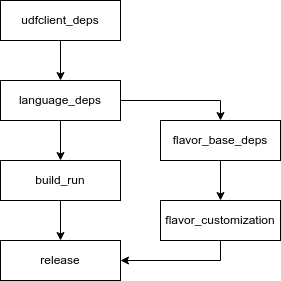


For customizing a flavor usually the flavor_customization build step is most important. It contains everything you need to add dependencies. The remaining build steps should be only changed with care, but sometimes some dependencies are defined in other build steps because the script client depends on them. 
Let's check the directory structure of the selected flavor.

In [ ]:
show_directory_content(slctmanager.slc_dir.flavor_dir, 2)

### Flavor Customization Build Step

The **flavor_customization** build step consists of a Dockerfile and several package lists which can be modified. We recommend to use the package lists to add new packages to the flavor and only modify the Dockerfile if you need very specific changes, like adding additional resources.

In [ ]:
show_directory_content(slctmanager.slc_dir.flavor_dir / "flavor_customization")

The Dockerfile consists of two parts. The first part installs the packages from the package list and should only be change with care. The second part is free for your changes. Read the description in the Dockerfile carefully to find out what you can and shouldn't do.

#### Package Lists
The package lists have a unified format. Each line consists of the package name and the package version separated by "|", e.g `xgboost|1.3.3`. You can comment out a whole line by adding"#" at the beginning. You can also add a trailing comment to a package definition by adding a "#" after the package definition. We usually recommend to pin the version, such that there are no surprises for which version gets installed.

In [ ]:
show_files([slctmanager.custom_pip_file])


We are now going to append the "xgboost" Python package to one of the package lists by adding `xgboost|2.0.3` and `scikit-learn|1.5.0` to the `flavor_customization/packages/python3_pip_packages` file. 
Notes:
 - running the following command multiple times will iteratively append the packages
 - you can also click on the link and modify the file directly


In [ ]:
xgboost_pkg = slct_manager.PipPackageDefinition(pkg="xgboost", version="2.0.3")
scikit_learn_pkg = slct_manager.PipPackageDefinition(pkg="scikit-learn", version="1.5.0")
slctmanager.append_custom_packages([xgboost_pkg, scikit_learn_pkg])
show_files([slctmanager.custom_pip_file])

#### Rebuilding the customized Flavor
After changing the flavor you need to rebuild it. You can do it by running `export` again. Exaslct automatically recognizes that the flavor has changed and builds a new version of the container.

In [ ]:
slctmanager.export()
print("Ready")

Note: Your old container doesn't get lost, because when you change a flavor your container gets a new hash code. If you revert your changes the system automatically uses the existing cached container. Below you can see the content of the cache directory for the containers.

In [ ]:
show_directory_content(slctmanager.working_path.output_path / "cache" / "exports")

### Testing the new Script-Language Container

Now, that we have an updated container, we need to check if our changes were successful. For that we are going to upload the container to an Exasol Database and have a look into it.

#### Upload the Container to the Database
To use our container we need to upload it to the BucketFS . If the build machine has access to the BucketFS we can do it with the exaslct upload command, otherwise you need to export the container and transfer it to a machine that has access to the BucketFS and upload it via curl, as described in our documentation.

With the following command we upload the new script language container.


In [ ]:
slctmanager.upload()

This command also stores the activation statement in the ai-lab-config.
We can verify it with:

In [ ]:
ai_lab_config.get(slct_manager.ACTIVATION_KEY)

The syntax is: `alias=url`. The alias is used when defining an UDF, the URL only for the language activation.
For simplicity the `SlctManager` provides easy access to the alias, as we need it later:

For simplicity the `SlctManager` provides access to the alias, as we need it later to define our UDF's:

In [ ]:
slctmanager.language_alias

#### Connecting to the database and activate the container
Once we have a connection to the database we run the ALTER SESSION statement or ALTER SYSTEM statement (if you want to activate the container permanently and globally) we got from `generate_language_activation`.
The `notebook` connector package provides a utility method, for creating an `pyexasol` connection and activating all registered languages:

In [ ]:
from exasol.nb_connector.language_container_activation import open_pyexasol_connection_with_lang_definitions

conn = open_pyexasol_connection_with_lang_definitions(ai_lab_config, compression=True)
conn.execute("CREATE SCHEMA SLC_TUTORIAL")

#### Check if your customization did work
We first create a helper UDF which allows us to run arbitrary shell commands inside of a UDF instance. With that we can easily inspect the container.

In [ ]:
import textwrap

conn.execute(textwrap.dedent(f"""
CREATE OR REPLACE {slctmanager.language_alias} SCALAR SCRIPT execute_shell_command_py3(command VARCHAR(2000000), split_output boolean)
EMITS (lines VARCHAR(2000000)) AS
import subprocess

def run(ctx):
    try:
        p = subprocess.Popen(ctx.command,
                             stdout    = subprocess.PIPE,
                             stderr    = subprocess.STDOUT,
                             close_fds = True,
                             shell     = True)
        out, err = p.communicate()
        if isinstance(out,bytes):
            out=out.decode('utf8')
        if ctx.split_output:
            for line in out.strip().split('\\n'):
                ctx.emit(line)
        else:
            ctx.emit(out)
    finally:
        if p is not None:
            try: p.kill()
            except: pass
/
"""))

Check with "pip list" if the "xgboost" package is installed
We use our helper UDF to run `python3 -m pip list` directly in the container and get the list of currently avaiable python3 packages.

In [ ]:
rs=conn.execute("""select execute_shell_command_py3('python3 -m pip list', true)""")
for r in rs: 
    print(r[0])

By running `pip list` directly in the container, we see what is currently available in the container. However, sometimes this might not be what we expected. For these cases, exaslct stores information about the flavor the container was build from within the container.

#### Embedded Build Information of the Container
Here we see an overview about the build information which exaslct embedded into the container. `exaslct` stores all packages lists (as defined in the flavor and what actually got installed), the final Dockerfiles and the image info. The image info describes how the underlying Docker images of the container got built. The build information is stored in the `/build_info` directory in the container. We can use again our helper UDF to inspect the build information.

In [ ]:
rs=conn.execute("""select execute_shell_command_py3('find /build_info', true)""")
for r in rs: 
    print(r[0])

The following command shows for example, which python3 package pip found directly after the build of the container image.

In [ ]:
rs=conn.execute("""select execute_shell_command_py3('cat /build_info/actual_installed_packages/release/python3_pip_packages', true)""")
for r in rs: 
    print(r[0])

You could for example compare this to the package list of the flavor-customization build step and check if all your requested packages got installed.

In [ ]:
rs=conn.execute("""select execute_shell_command_py3('cat /build_info/packages/flavor_customization/python3_pip_packages', true)""")
for r in rs:
    if r[0] is None:
        print()
    else:
        print(r[0])

### Testing the new package

After we made sure that the required packages are installed, we need to try importing and using it. Importing is usually a good first test if a package got successfully installed, because often you might already get errors at this step. However, sometimes you only will recognize errors when using the package. We recommend to have a test suite for each new package to check if it works properly before you start your UDF development. It is usually easier to debug problems if you have very narrow tests.

In [ ]:
conn.execute(textwrap.dedent(f"""
CREATE OR REPLACE {slctmanager.language_alias} SET SCRIPT test_xgboost(i integer)
EMITS (o VARCHAR(2000000)) AS

def run(ctx):
    import xgboost
    import sklearn 
    
    ctx.emit("success")
/
"""))

rs = conn.execute("select test_xgboost(1)")
rs.fetchall()

In [ ]:
conn.execute(textwrap.dedent("""
CREATE OR REPLACE PYTHON3 SET SCRIPT test_xgboost(i integer)
EMITS (o1 DOUbLE, o2 DOUbLE, o3 DOUbLE) AS

def run(ctx):
    import pandas as pd
    import xgboost as xgb
    from sklearn import datasets
    from sklearn.model_selection import train_test_split
    
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    param = {
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 3  # the number of classes that exist in this datset
        }
    num_round = 20  # the number of training iterations
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)
    
    ctx.emit(pd.DataFrame(preds))
/
"""))

conn.export_to_pandas("select test_xgboost(1)")